<a href="https://colab.research.google.com/github/swilsonmfc/pandas/blob/main/8_Lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotel Bookings

![](https://cdn.inprnt.com/thumbs/5b/fa/5bfa6a8ea6c461d1c21c0a44962968ed.jpg?response-cache-control=max-age=2628000)

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as regplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data
* https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [2]:
!wget -O hotel.zip https://github.com/swilsonmfc/pandas/blob/main/hotel.zip?raw=true

--2021-07-22 13:23:58--  https://github.com/swilsonmfc/pandas/blob/main/hotel.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/swilsonmfc/pandas/raw/main/hotel.zip [following]
--2021-07-22 13:23:58--  https://github.com/swilsonmfc/pandas/raw/main/hotel.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/swilsonmfc/pandas/main/hotel.zip [following]
--2021-07-22 13:23:58--  https://raw.githubusercontent.com/swilsonmfc/pandas/main/hotel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1308365 (1.2M) [applic

In [3]:
!unzip hotel.zip

Archive:  hotel.zip
replace hotel_bookings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
hotel_df = pd.read_csv('./hotel_bookings.csv')

In [5]:
hotel_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


## Types

In [6]:
hotel_df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

## Missing
* Missing data here seems reasonable for the most part
* 4 missing children - Impute to median

In [7]:
hotel_df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
# Series where method vs np.where
hotel_df['children'] = hotel_df.children.where(hotel_df.children.notna(), 0)
hotel_df['country']  = hotel_df.country.fillna('UNKNOWN')
hotel_df['agent']    = hotel_df.agent.fillna('NONE')
hotel_df['company']  = hotel_df.company.fillna('NONE')

In [9]:
hotel_df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

## Outliers
* More than 10 people booked in a room
  * All cancelled
  * Agent 96 is present on 1/2 of them
* The hotel paid one person to stay there
  * Best to truncate that to $0
  * One room cost \$5,400

In [10]:
hotel_df = hotel_df[(hotel_df.adr >= 0) & (hotel_df.adr < 1000)]

# Classification Problems

![](https://static.javatpoint.com/tutorial/machine-learning/images/classification-algorithm-in-machine-learning.png)

## Logistic Regression
* Could we use linear regression to classify?
* Our target values all fall on two lines 
  * Y=1 is canceled
  * Y=0 is not canceled

![](https://miro.medium.com/max/376/1*xFhICZgdr2VEZQ-C4FLUEA.jpeg)

![](https://www.gstatic.com/education/formulas2/355397047/en/logit.svg)

### Odds

In [64]:
# Odds = ratio of prob / 1 - prob
# 80% chance of winning
print(f'If 80% chance of winning, odds {.8 / (1 - .8):.2f}')
print(f'If 50% chance of winning, odds {.5 / (1 - .5):.2f}')
print(f'If 20% chance of winning, odds {.2 / (1 - .2):.2f}')

If 80% chance of winning, odds 4.00
If 50% chance of winning, odds 1.00
If 20% chance of winning, odds 0.25


### Odds -> Log Odds

In [65]:
# Log odds is the logarithm of odds
# Logs are numerically friendly - turn multiplication into addition
# log(p / (1-p)) = log(p) - log(1-p)
# Log odds > 0 when you have a greater than 50% chance
# Log odds = 0 when you have a 50-50 chance of winning
# Log odds < 0 when you have a less than 50% chance
print(f'If 80% chance of winning, log odds {np.log(.8 / (1 - .8)):.2f}')
print(f'If 50% chance of winning, log odds {np.log(.5 / (1 - .5)):.2f}')
print(f'If 20% chance of winning, log odds {np.log(.2 / (1 - .2)):.2f}')

If 80% chance of winning, log odds 1.39
If 50% chance of winning, log odds 0.00
If 20% chance of winning, log odds -1.39


### Log Odds -> Odds
* Exponentiate log odds to get to odds

In [71]:
odds     = .8 / (1 - .8) 
log_odds = np.log(odds)
exp_odds = np.exp(log_odds)
print(f'Odds {odds:.2f}')
print(f'log(odds) -> Log Odds {log_odds:.2f}')
print(f'exp(log_odds) -> Odds {exp_odds:.2f}')

Odds 4.00
log(odds) -> Log Odds 1.39
exp(log_odds) -> Odds 4.00


## Univariate

In [11]:
f = 'is_canceled ~ lead_time'
model = smf.logit(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.616284
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               119388
Model:                          Logit   Df Residuals:                   119386
Method:                           MLE   Df Model:                            1
Date:                Thu, 22 Jul 2021   Pseudo R-squ.:                 0.06507
Time:                        13:24:06   Log-Likelihood:                -73577.
converged:                       True   LL-Null:                       -78698.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1656      0.009   -126.943      0.000      -1.184      -1.148
lead_time      0.0059   6.14e

### Key Fields
* Log-Likelihood is the log likelihood of the model with the best fit of parameters to the data
* LL-Null is the log likelihood of the model with only an intercept term
* Pseudo R-squ. Ratio of the LL-Null compared to Log-Likelihood

In [12]:
pd.DataFrame(fitted.pred_table()).astype(int)

,0,1
0,66661,8504
1,31937,12286


In [13]:
proba = fitted.predict(hotel_df.lead_time)
pred  = np.where(proba < .5, 0, 1)
cm = confusion_matrix(hotel_df.is_canceled, pred)
pd.DataFrame(cm)

,0,1
0,66661,8504
1,31937,12286


In [14]:
print(f'Accuracy {accuracy_score(hotel_df.is_canceled, pred):.3}')

Accuracy 0.661


## Multiple

In [15]:
f = 'is_canceled ~ lead_time + stays_in_weekend_nights + stays_in_week_nights'
model = smf.logit(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.615814
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               119388
Model:                          Logit   Df Residuals:                   119384
Method:                           MLE   Df Model:                            3
Date:                Thu, 22 Jul 2021   Pseudo R-squ.:                 0.06578
Time:                        13:24:07   Log-Likelihood:                -73521.
converged:                       True   LL-Null:                       -78698.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0907      0.012    -91.649      0.000      -1.114   

In [16]:
pd.DataFrame(fitted.pred_table()).astype(int)

,0,1
0,66786,8379
1,31940,12283


In [17]:
proba = fitted.predict(hotel_df[['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights']])
pred  = np.where(proba < .5, 0, 1)
cm = confusion_matrix(hotel_df.is_canceled, pred)
pd.DataFrame(cm)

,0,1
0,66786,8379
1,31940,12283


## Assumptions
* Observations must be independent of each other
* No multicollinearity between independent variables (low correlation)
* Does not assume the linear relationship between dependent and independent variables (as in LinearRegression)
* But there is a assumption that the independent variable and log odds are linearly related

## Predictions


In [18]:
f = 'is_canceled ~ hotel + arrival_date_month + lead_time'
model = smf.logit(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.607159
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               119388
Model:                          Logit   Df Residuals:                   119374
Method:                           MLE   Df Model:                           13
Date:                Thu, 22 Jul 2021   Pseudo R-squ.:                 0.07891
Time:                        13:24:09   Log-Likelihood:                -72487.
converged:                       True   LL-Null:                       -78698.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.7795      0.021    -36.408  

In [19]:
pred_df = pd.DataFrame([{'hotel': 'City Hotel', 'arrival_date_month': 'July', 'lead_time': 1},
                        {'hotel': 'Resort Hotel', 'arrival_date_month': 'December', 'lead_time': 730}])
pred_df

,hotel,arrival_date_month,lead_time
0,City Hotel,July,1
1,Resort Hotel,December,730


In [20]:
predictions = fitted.predict(pred_df)
predictions

0    0.236095
1    0.951296
dtype: float64

In [21]:
predicted_class = np.where(predictions < 0.5, 0, 1)
predicted_class

array([0, 1])

# Sklearn
* Statsmodels is focused on statistical modeling
  * "Model should satisfy its assumptions"
  * Descriptive summary
  * Often guided by "Stargazing"
  * Formula driven
* Sklearn is focused on predictive modeling
  * "Model should do well at forecasting"
  * Use Error Measures
  * Hold out / Cross fold validation
  * Preprocessing Data

## Loss Metrics

![](https://miro.medium.com/max/1400/1*pOtBHai4jFd-ujaNXPilRg.png)

## Tools

### Train - Test - Split
* We need to test how well our model has learned to complete a task



### Standard Scaler
* Scaling data improves the ability to converge (makes the problem easier to solve)
* To scale, subtract the mean and divide by the standard deviation
* In sklearn, we use the training data set to estimate mean and standard deviation
* Apply to both train and test sets
* The StandardScaler class makes this easy to use

In [22]:
sample = hotel_df[['lead_time']].copy()
scaler = StandardScaler()
sample['lead_time_scaled'] = scaler.fit_transform(sample)
sample.head()

,lead_time,lead_time_scaled
0,342,2.227045
1,737,5.923365
2,7,-0.907809
3,13,-0.851662
4,14,-0.842305


In [23]:
print(scaler.mean_)

[104.01123228]


### One Hot Encoding
* We have to build the matrix of dummy values for our regression in sklearn
* Categorical variables (i.e. strings) need to be converted to matrix of 0s and 1s
* Two Main Approaches
  * One Hot Encoder 
  * Pandas get_dummies

In [24]:
sample = hotel_df[['arrival_date_month']].copy()
sample.head()

,arrival_date_month
0,July
1,July
2,July
3,July
4,July


In [25]:
pd.get_dummies(sample).head()

,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0


In [26]:
sample = hotel_df[['arrival_date_month']].copy()
ohe = OneHotEncoder()
pd.DataFrame(ohe.fit_transform(sample).todense(), columns=ohe.get_feature_names()).head()

,x0_April,x0_August,x0_December,x0_February,x0_January,x0_July,x0_June,x0_March,x0_May,x0_November,x0_October,x0_September
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Logistic Regression

### Train - Test
* Randomly assign data into training and test sets
* Learn from training
* Evaluate accuracy on test 

In [27]:
# Pull features and target
X = hotel_df.copy()
y = X.pop('is_canceled')
X = X[['lead_time', 'arrival_date_month']]

In [28]:
X.head()

,lead_time,arrival_date_month
0,342,July
1,737,July
2,7,July
3,13,July
4,14,July


### Pre-Process

In [29]:
# Get dummy variables 
X = pd.get_dummies(X, columns=['arrival_date_month'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y)

# Scale numeric columns
scaler = StandardScaler()
X_train['lead_time'] = scaler.fit_transform(X_train[['lead_time']])
X_test['lead_time']  = scaler.transform(X_test[['lead_time']])

In [30]:
X_train.head()

,lead_time,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
63335,4.459839,0,0,0,1,0,0,0,0,0,0,0,0
68703,-0.636561,0,0,0,0,0,0,0,0,1,0,0,0
99239,-0.861402,0,0,0,0,0,0,0,0,0,0,1,0
75809,2.117744,0,0,0,0,0,0,0,0,0,0,0,1
72031,0.749960,0,0,0,0,0,1,0,0,0,0,0,0


In [31]:
X_test.head()

,lead_time,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
111096,0.515750,0,0,0,0,0,0,0,0,1,0,0,0
43346,-0.280562,0,0,0,0,0,0,0,0,0,0,0,1
11153,0.244067,1,0,0,0,0,0,0,0,0,0,0,0
109022,-0.627193,1,0,0,0,0,0,0,0,0,0,0,0
32770,-0.973823,0,0,0,1,0,0,0,0,0,0,0,0


### Fit 
* Fit the model
* We no longer get a summary of model assumptions / diagnostics

In [32]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predict
* We can predict the proabability of being in one class or another
* We can predict the class (predict uses a cutoff of 0.5 corresponding to a sigmoid)

In [33]:
# Predict both probability and class
proba = model.predict_proba(X_test)
preds = model.predict(X_test)

In [34]:
proba

array([[0.55168931, 0.44831069],
       [0.70160623, 0.29839377],
       [0.54092276, 0.45907724],
       ...,
       [0.53821732, 0.46178268],
       [0.51112492, 0.48887508],
       [0.768114  , 0.231886  ]])

In [35]:
preds

array([0, 0, 0, ..., 0, 0, 0])

### Score

In [36]:
# Scoring reports accuracy
model.score(X_test, y_test)

0.6639193218748953

In [37]:
# Classification report gives a better picture
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77     18713
           1       0.60      0.29      0.39     11134

    accuracy                           0.66     29847
   macro avg       0.64      0.59      0.58     29847
weighted avg       0.65      0.66      0.63     29847



# Concerns
* Three areas to attend to when building models with sklearn
* Class balance - Tend to perform best when we have balanced classes
  * Relevant for classification problems
  * Assigns weights to the prevalence
  * Oversample minority class
  * Undersample majority class
* What should be in the model?
  * One approach is Lasso
  * Lasso adds a penalty for coefficients
  * Lasso leads to "sparsity"
  * Lasso can force many coefficients in a model to 0, helping you identify what to keep
* Lucky / Unlucky split of the data 
  * Perform several splits
  * Average results
  * Cross-fold validation to estimate performance
  * Build final model using all data

## Class Balance

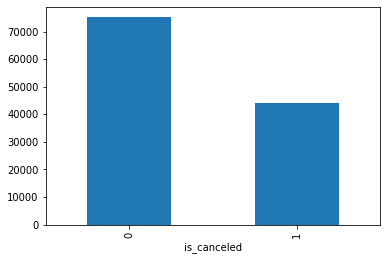

In [38]:
hotel_df.groupby('is_canceled').size().plot.bar()

In [39]:
# Pull features and target
X = hotel_df.copy()
y = X.pop('is_canceled')
X = X[['lead_time', 'arrival_date_month']]

In [40]:
# Pre-Process
X = pd.get_dummies(X, columns=['arrival_date_month'])
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y)
scaler = StandardScaler()
X_train['lead_time'] = scaler.fit_transform(X_train[['lead_time']])
X_test['lead_time']  = scaler.transform(X_test[['lead_time']])

In [41]:
# Determine weights
weight = len(y_train) / sum(y_train)
weights = {0: 1, 1: weight}
weights

{0: 1, 1: 2.6995387259187797}

In [42]:
# Construct a model with the class weights
model = LogisticRegression(class_weight=weights)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 2.6995387259187797},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [43]:
# Generate predictions on the test set
proba = model.predict_proba(X_test)
preds = model.predict(X_test)
print(f'Accuracy {model.score(X_test, y_test):.2f}')

Accuracy 0.57


In [44]:
# Accuracy went down overall, but recall on minority class went up
# What are our goals?
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.80      0.42      0.55     18793
           1       0.46      0.83      0.59     11054

    accuracy                           0.57     29847
   macro avg       0.63      0.62      0.57     29847
weighted avg       0.67      0.57      0.56     29847



## Lasso Regression
* An extension to Logistic / Linear Regression
* Adds a penalty to the loss function
* Also called L1 norm, this is the sum of the absolute values of the coefficients
* L1 Penalty helps push superfluous features to coefficients = 0
* That leads to "sparsity" i.e. Feature Selection

In [45]:
# Pull Features & target
X = hotel_df.copy()
y = X.pop('is_canceled')
X = X[['lead_time', 'country']]

In [46]:
# Preprocess data & split into train - test
X = pd.get_dummies(X, columns=['country'])
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y)
scaler = StandardScaler()
X_train['lead_time'] = scaler.fit_transform(X_train[['lead_time']])
X_test['lead_time']  = scaler.transform(X_test[['lead_time']])

In [47]:
# We specific l1 for penalty, solver = sage
# C controls the level of penalty (Higher = More)
lasso = LogisticRegression(penalty='l1', solver='saga', C=1)
lasso.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
# Many coefficients are now zero
pd.DataFrame([{'Coefficient': c, 'Value': v.squeeze()} 
              for c, v in zip(list(X_train.columns), lasso.coef_.T)])

,Coefficient,Value
0,lead_time,0.74565401697897
1,country_ABW,0.0
2,country_AGO,1.6512697130341543
3,country_AIA,0.0
4,country_ALB,-0.006598488513433068
...,...,...
174,country_VGB,0.0
175,country_VNM,-0.024085693350533698
176,country_ZAF,0.6341903071019614
177,country_ZMB,0.0


In [49]:
# Generate predictions on the test set
proba = lasso.predict_proba(X_test)
preds = lasso.predict(X_test)
print(f'Accuracy {lasso.score(X_test, y_test):.2f}')

Accuracy 0.75


In [50]:
# Compared with using month (accuracy of .67) country improved our results
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82     18834
           1       0.73      0.50      0.59     11013

    accuracy                           0.75     29847
   macro avg       0.74      0.70      0.70     29847
weighted avg       0.75      0.75      0.73     29847



## Cross-Fold Validation

![](https://zitaoshen.rbind.io/project/machine_learning/machine-learning-101-cross-vaildation/featured.png)

In [51]:
# Get features
X = hotel_df.copy()
y = X.pop('is_canceled')
X = X[['lead_time', 'arrival_date_month']]

In [52]:
# Preprocess Data - No need to train-test-split
X = pd.get_dummies(X, columns=['arrival_date_month'])
scaler = StandardScaler()
X_train['lead_time'] = scaler.fit_transform(X_train[['lead_time']])
X_test['lead_time']  = scaler.transform(X_test[['lead_time']])

In [53]:
# Define folds and train model
cv = KFold(n_splits=5, shuffle=True, random_state=1000)
model_cv = LogisticRegression()
scores = cross_val_score(model_cv, X, y, scoring='accuracy', cv=cv)

In [54]:
# Inspect scores (Then build model with all data -- not illustrated)
print(f'Accuracy Mean {np.mean(scores):.2f} Std {np.std(scores):.4f}')
pd.DataFrame(scores)

Accuracy Mean 0.66 Std 0.0016


,0
0,0.664629
1,0.665131
2,0.662535
3,0.661138
4,0.661348
